# 四公式標籤 + meta 表建立 & 分數時序圖

1. 讀取指定資料夾內的轉轍器 CSV 檔案
2. 對每一檔計算四個特徵（input1–4）
3. 使用 `calculate_score` 計算四個公式分數（score1–4），並加總成四公式總分
4. 依四公式總分分成「正常 / 異常 / 故障」三類並輸出到對應資料夾
5. 建立一份 `labels_v2_four_formula.csv` 的 meta 表
6. 畫出「時間 vs 四公式總分」的時序圖


In [36]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

# 1. 匯入 & 路徑設定

# 讀取 CSV 的路徑（請依實際環境修改）
csv_files = glob.glob("/home/t113ab8043/Desktop/nanten_railway_code/資料集/A16/P1602R/P*.csv")
print(f"找到 {len(csv_files)} 個 CSV 檔")

# 三個結果資料夾（正常、異常、故障）
output_base = "/home/t113ab8043/Desktop/nanten_railway_code/資料集/已處理資料/6score/P1602R"
folder_normal   = os.path.join(output_base, "正常")
folder_abnormal = os.path.join(output_base, "異常")
folder_faulty   = os.path.join(output_base, "故障")

for folder in [folder_normal, folder_abnormal, folder_faulty]:
    os.makedirs(folder, exist_ok=True)


找到 473 個 CSV 檔


In [ ]:
# 2. 分數計算 & 從單一 CSV 抽 input1～4

def calculate_score(score, score_divisor, bias: float = 0.0) -> float:
    """依四段區間計算單一公式的 0–25 分數。"""
    upper = score_divisor * 2.0
    standard = score_divisor
    lower = score_divisor / 2.0 + bias
    lowest = score_divisor / 24.0

    if score > upper:
        return 0.0
    elif upper >= score > standard:
        return (100.0 - (score - standard) / standard * 100.0) * 0.25
    elif standard >= score > lower:
        return 25.0
    elif lower >= score > lowest:
        return (100.0 - ((lower - score) / lower) * 100.0) * 0.25
    else:
        return 0.0

# Average 
peak_current_divisor_default   = 2.4
avg_current_divisor_default    = 2.4
rotation_time_divisor_default  = 2.75
power_divisor_default          = 288.0


def extract_inputs_from_csv(file_path: str):
    df = pd.read_csv(file_path)

    # 刪除不必要欄位
    for col in ["TURNCOUNT", "ALARMCODE", "Unnamed: 15"]:
        if col in df.columns:
            df = df.drop(columns=[col])

    # 確認必要欄位
    required_cols = [
        "NWKR", "RWKR", "SNWKR", "SRWKR",
        "NLR", "DataTime", "WRVT",
        "NCurrent", "RCurrent",
    ]

    # Debug: 檢查缺少的欄位
    missing = [c for c in required_cols if c not in df.columns]
    if missing:
        raise ValueError(f"{os.path.basename(file_path)} 缺少欄位: {missing}")

    # 1) area = 四個旗標相加
    area = df["NWKR"] + df["RWKR"] + df["SNWKR"] + df["SRWKR"]

    # 2) 旋轉時間：area = 0 或 1 的點數 / 100（假設 100 Hz）
    mask_rot = (area == 0) | (area == 1)
    rotation_time_sec = mask_rot.sum() / 100.0
    
    # 3) 工作區間：area == 0
    df_work = df[area == 0].copy()
    if df_work.empty:
        raise ValueError(f"{os.path.basename(file_path)} 沒有 area == 0 的工作區間")
    
    # 4) 根據 NLR 選 NCurrent / RCurrent
    first_nlr = int(df["NLR"].iloc[0])
    current_col = "NCurrent" if first_nlr == 1 else "RCurrent"
    df_work[current_col] = df_work[current_col].fillna(0)

    # 5) 平均工作電流
    average_working_current = df_work[current_col].mean()

    # 6) 平均功率 = Current * WRVT
    df_work["power_w"] = df_work[current_col] * df_work["WRVT"]
    working_power_w = df_work["power_w"].mean()

    # 7) Top5 peak 電流
    peaks = df_work[current_col].nlargest(5).tolist()
    if len(peaks) < 5:
        peaks += [0.0] * (5 - len(peaks))
    input1_peak_mean = float(np.mean(peaks))

    inputs = {
        "input1_peak_mean":     input1_peak_mean,
        "input2_avg_current":   float(average_working_current),
        "input3_rotation_time": float(rotation_time_sec),
        "input4_power":         float(working_power_w),
    }
    return df, inputs


def classify_by_four_formulas(inputs: dict):
    s1 = calculate_score(inputs["input1_peak_mean"],     peak_current_divisor_default, 0.3)
    s2 = calculate_score(inputs["input2_avg_current"],   avg_current_divisor_default, 0.3)
    s3 = calculate_score(inputs["input3_rotation_time"], rotation_time_divisor_default, 0.3)
    s4 = calculate_score(inputs["input4_power"],         power_divisor_default, 0.3)

    four_total = s1 + s2 + s3 + s4
    avg_score = four_total / 4.0

    if four_total >= 80.0:
        class_name = "0"
    elif four_total >= 60.0:
        class_name = "1"
    else:
        class_name = "2"

    info = {
        "score1": s1,
        "score2": s2,
        "score3": s3,
        "score4": s4,
        "four_formula_total": four_total,
        "avg_score": avg_score,
        "class_name": class_name,
    }
    return class_name, info


In [38]:
# 3. 主迴圈：逐檔計算分數 → 分類 → 存檔 & 建立 meta 表

def parse_filename(file_path: str):
    base = os.path.basename(file_path)
    name = os.path.splitext(base)[0]
    turnout_id = name[:5]
    n_r = name[5] if len(name) > 5 else "?"
    return turnout_id, n_r

all_rows = []

for file in csv_files:
    try:
        df, inputs = extract_inputs_from_csv(file)
        class_name, info = classify_by_four_formulas(inputs)
    except Exception as e:
        print(f"[SKIP] {os.path.basename(file)} 分類失敗：{e}")
        continue

    try:
        tms_time = pd.to_datetime(df["DataTime"].iloc[0])
    except Exception:
        tms_time = pd.NaT

    turnout_id, n_r = parse_filename(file)

    df["input1_peak_mean"]     = inputs["input1_peak_mean"]
    df["input2_avg_current"]   = inputs["input2_avg_current"]
    df["input3_rotation_time"] = inputs["input3_rotation_time"]
    df["input4_power"]         = inputs["input4_power"]

    df["score1"] = info["score1"]
    df["score2"] = info["score2"]
    df["score3"] = info["score3"]
    df["score4"] = info["score4"]
    df["four_formula_total"] = info["four_formula_total"]
    df["avg_score"]          = info["avg_score"]
    df["health_category"]    = info["class_name"]

    if class_name == "0":
        target_folder = folder_normal
    elif class_name == "2":
        target_folder = folder_faulty
    else:
        target_folder = folder_abnormal

    base_name = os.path.splitext(os.path.basename(file))[0]
    out_name = f"{base_name}_{class_name}.csv"
    out_path = os.path.join(target_folder, out_name)
    df.to_csv(out_path, index=False, encoding="utf-8-sig")
    print(f"{os.path.basename(file)} → {class_name} | four_total={info['four_formula_total']:.1f} → {out_path}")

    all_rows.append({
        "file_path": file,
        "saved_path": out_path,
        "Turnout_Id": turnout_id,
        "n_r": n_r,
        "TMS_time": tms_time,
        "input1_peak_mean": inputs["input1_peak_mean"],
        "input2_avg_current": inputs["input2_avg_current"],
        "input3_rotation_time": inputs["input3_rotation_time"],
        "input4_power": inputs["input4_power"],
        "score1": info["score1"],
        "score2": info["score2"],
        "score3": info["score3"],
        "score4": info["score4"],
        "four_formula_total": info["four_formula_total"],
        "avg_score": info["avg_score"],
        "health_category": info["class_name"],
    })

print("全部檔案分類完成！")

meta = pd.DataFrame(all_rows)
os.makedirs(output_base, exist_ok=True)
meta_path = os.path.join(output_base, "labels_v2_four_formula.csv")
meta.to_csv(meta_path, index=False, encoding="utf-8-sig")
print(f"label 總表已存到：{meta_path}")
display(meta.head())


P1602R_20230803033728.csv → 0 | four_total=90.1 → /home/t113ab8043/Desktop/nanten_railway_code/資料集/已處理資料/6score/P1602R/正常/P1602R_20230803033728_0.csv
P1602R_20230629044203.csv → 1 | four_total=79.6 → /home/t113ab8043/Desktop/nanten_railway_code/資料集/已處理資料/6score/P1602R/異常/P1602R_20230629044203_1.csv
P1602R_20230514045614.csv → 1 | four_total=66.7 → /home/t113ab8043/Desktop/nanten_railway_code/資料集/已處理資料/6score/P1602R/異常/P1602R_20230514045614_1.csv
P1602R_20230910044906.csv → 1 | four_total=71.4 → /home/t113ab8043/Desktop/nanten_railway_code/資料集/已處理資料/6score/P1602R/異常/P1602R_20230910044906_1.csv
P1602R_20230914033132.csv → 1 | four_total=75.6 → /home/t113ab8043/Desktop/nanten_railway_code/資料集/已處理資料/6score/P1602R/異常/P1602R_20230914033132_1.csv
P1602R_20230427043305.csv → 1 | four_total=69.0 → /home/t113ab8043/Desktop/nanten_railway_code/資料集/已處理資料/6score/P1602R/異常/P1602R_20230427043305_1.csv
P1602R_20230625034143.csv → 0 | four_total=82.5 → /home/t113ab8043/Desktop/nanten_railway_code/資料集/已

,file_path,saved_path,Turnout_Id,n_r,TMS_time,input1_peak_mean,input2_avg_current,input3_rotation_time,input4_power,score1,score2,score3,score4,four_formula_total,avg_score,health_category
0,/home/t113ab8043/Desktop/nanten_railway_code/資...,/home/t113ab8043/Desktop/nanten_railway_code/資...,P1602,R,2023-08-03 03:37:28,2.98,2.507895,2.43,319.871930,18.958333,23.876096,25.0,22.233339,90.067769,22.516942,0
1,/home/t113ab8043/Desktop/nanten_railway_code/資...,/home/t113ab8043/Desktop/nanten_railway_code/資...,P1602,R,2023-06-29 04:42:03,3.36,2.815323,2.42,358.210484,15.000000,20.673723,25.0,18.905340,79.579063,19.894766,1
2,/home/t113ab8043/Desktop/nanten_railway_code/資...,/home/t113ab8043/Desktop/nanten_railway_code/資...,P1602,R,2023-05-14 04:56:14,3.84,3.163200,2.65,407.407200,10.000000,17.050000,25.0,14.634792,66.684792,16.671198,1
3,/home/t113ab8043/Desktop/nanten_railway_code/資...,/home/t113ab8043/Desktop/nanten_railway_code/資...,P1602,R,2023-09-10 04:49:06,3.54,3.102752,2.49,395.887156,13.125000,17.679664,25.0,15.634795,71.439459,17.859865,1
4,/home/t113ab8043/Desktop/nanten_railway_code/資...,/home/t113ab8043/Desktop/nanten_railway_code/資...,P1602,R,2023-09-14 03:31:32,3.42,2.966667,2.39,378.552846,14.375000,19.097222,25.0,17.139510,75.611732,18.902933,1


In [39]:
# 類別筆數統計
print("\n各類別筆數統計：")
print(meta["health_category"].value_counts())


各類別筆數統計：
health_category
1    294
0    160
2     19
Name: count, dtype: int64


可畫圖紀錄數量：473


/tmp/ipykernel_918802/2786377049.py:24: UserWarning: Glyph 22235 (\N{CJK UNIFIED IDEOGRAPH-56DB}) missing from font(s) DejaVu Sans.
  plt.savefig(out_path, dpi=150, bbox_inches="tight")
/tmp/ipykernel_918802/2786377049.py:24: UserWarning: Glyph 20844 (\N{CJK UNIFIED IDEOGRAPH-516C}) missing from font(s) DejaVu Sans.
  plt.savefig(out_path, dpi=150, bbox_inches="tight")
/tmp/ipykernel_918802/2786377049.py:24: UserWarning: Glyph 24335 (\N{CJK UNIFIED IDEOGRAPH-5F0F}) missing from font(s) DejaVu Sans.
  plt.savefig(out_path, dpi=150, bbox_inches="tight")
/tmp/ipykernel_918802/2786377049.py:24: UserWarning: Glyph 32317 (\N{CJK UNIFIED IDEOGRAPH-7E3D}) missing from font(s) DejaVu Sans.
  plt.savefig(out_path, dpi=150, bbox_inches="tight")
/tmp/ipykernel_918802/2786377049.py:24: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  plt.savefig(out_path, dpi=150, bbox_inches="tight")
/tmp/ipykernel_918802/2786377049.py:24: UserWarning: Glyph 26178 (\N{C

已輸出：/home/t113ab8043/Desktop/nanten_railway_code/資料集/已處理資料/6score/P1602R/plots_four_formula/P1602_R_four_formula_timeseries.png


/home/t113ab8043/.conda/envs/switch_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22235 (\N{CJK UNIFIED IDEOGRAPH-56DB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/t113ab8043/.conda/envs/switch_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20844 (\N{CJK UNIFIED IDEOGRAPH-516C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/t113ab8043/.conda/envs/switch_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24335 (\N{CJK UNIFIED IDEOGRAPH-5F0F}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/t113ab8043/.conda/envs/switch_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32317 (\N{CJK UNIFIED IDEOGRAPH-7E3D}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/t113ab8043/.conda/envs/switch_env/lib/python3.10/site-

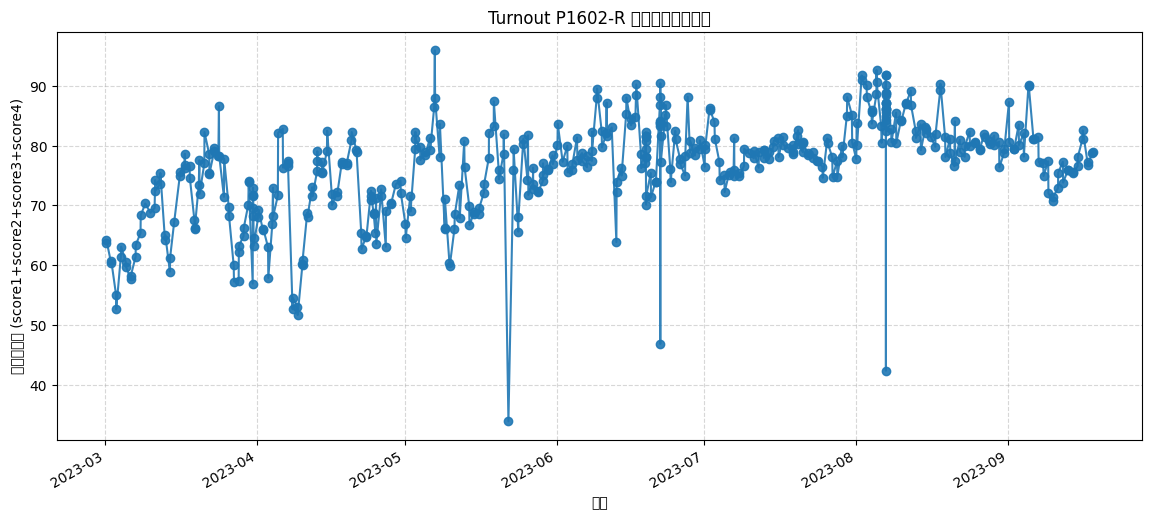

In [40]:
# 4. 畫「時間 vs 四公式總分」時序圖

meta["TMS_time"] = pd.to_datetime(meta["TMS_time"], errors="coerce")
meta_plot = meta.dropna(subset=["TMS_time"]).copy()
meta_plot["four_formula_sum"] = meta_plot[["score1", "score2", "score3", "score4"]].sum(axis=1)

plot_folder = os.path.join(output_base, "plots_four_formula")
os.makedirs(plot_folder, exist_ok=True)

print(f"可畫圖紀錄數量：{len(meta_plot)}")

for (turnout_id, n_r), group in meta_plot.groupby(["Turnout_Id", "n_r"]):
    group = group.sort_values("TMS_time")

    plt.figure(figsize=(14, 6))
    plt.plot(group["TMS_time"], group["four_formula_sum"], marker="o", linestyle="-", alpha=0.9)
    plt.title(f"Turnout {turnout_id}-{n_r} 四公式總分時序圖")
    plt.xlabel("時間")
    plt.ylabel("四公式總分 (score1+score2+score3+score4)")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.gcf().autofmt_xdate()

    out_path = os.path.join(plot_folder, f"{turnout_id}_{n_r}_four_formula_timeseries.png")
    plt.savefig(out_path, dpi=150, bbox_inches="tight")
    print(f"已輸出：{out_path}")
    plt.show()
